<a href="https://colab.research.google.com/github/LeoMcBills/ML-Algo-Exploration/blob/main/malariaPredictionmbubesa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preparation

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Input
from keras.src.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC

In [2]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=["train"])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteP10CJ5/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [4]:
def split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
  val_testdataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_testdataset.take(int(VAL_RATIO*DATASET_SIZE))
  test_dataset = val_testdataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [5]:
train_dataset, val_dataset, test_dataset = split(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
print(list(train_dataset.take(1).as_numpy_iterator()),
      list(val_dataset.take(1).as_numpy_iterator()),
      list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

In [6]:
for data in dataset[0].take(1):
  print(data)

(<tf.Tensor: shape=(151, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


# Data visualizaion

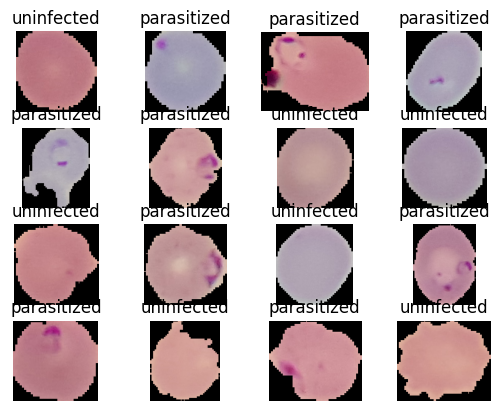

In [7]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

# Data Processing

In [8]:
IM_SIZE = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [9]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [10]:
for image, label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [11]:
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

# Model creation

In [12]:
model = tf.keras.Sequential([
                            InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

                            Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
                            BatchNormalization(),
                            MaxPool2D(pool_size=2, strides=2),

                            Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
                            BatchNormalization(),
                            MaxPool2D(pool_size=2, strides=2),

                            Flatten(),

                            Dense(1000, activation='sigmoid'),
                            BatchNormalization(),
                            Dense(100, activation='sigmoid'),
                            BatchNormalization(),
                            Dense(1, activation="sigmoid"),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

# Functional API

In [13]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name='Input image')

x = Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Flatten()(x)

x = Dense(1000, activation='sigmoid')(x)
x = BatchNormalization()(x)

x = Dense(100, activation='sigmoid')(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

model = Model(func_input, func_output, name="Model")
model.summary()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16)      64    

In [14]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name='Input image')

x = Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2, strides=2)(x)

feature_extractor = Model(func_input, output, name="feature_extractor")
feature_extractor.summary()

Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_8 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_9 (Bat  (None, 109, 109, 16)

In [15]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name='Input image')

x = feature_extractor(func_input)

x = Flatten()(x)

x = Dense(1000, activation='sigmoid')(x)
x = BatchNormalization()(x)

x = Dense(100, activation='sigmoid')(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

model = Model(func_input, func_output, name="Model")
model.summary()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (Functio  (None, 54, 54, 16)        1136      
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 dense_6 (Dense)             (None, 1000)              46657000  
                                                                 
 batch_normalization_10 (Ba  (None, 1000)              4000      
 tchNormalization)                                               
                                                                 
 dense_7 (Dense)             (None, 100)               100100

# Model Subclassing

In [16]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size,):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size=pool_size, strides=2*strides)

    self.conv_2 = Conv2D(filters=2*filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size=pool_size, strides=2*strides)

  def call(self, x):

    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x

feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

In [17]:
metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
           BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

In [18]:
model.compile(optimizer=Adam(learning_rate=0.01),
              loss=BinaryCrossentropy(),
              metrics=metrics)

# Training

In [19]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=30, verbose=1)

Epoch 1/30
689/689 [==============================] - 91s 100ms/step - loss: 0.6799 - tp: 7124.0000 - fp: 5014.0000 - tn: 6008.0000 - fn: 3900.0000 - accuracy: 0.5957 - precision: 0.5869 - recall: 0.6462 - auc: 0.6266 - val_loss: 1.3390 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1363.0000 - val_fn: 1392.0000 - val_accuracy: 0.4947 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3838
Epoch 2/30
689/689 [==============================] - 48s 70ms/step - loss: 0.6874 - tp: 6093.0000 - fp: 5416.0000 - tn: 5608.0000 - fn: 4929.0000 - accuracy: 0.5308 - precision: 0.5294 - recall: 0.5528 - auc: 0.5523 - val_loss: 0.8772 - val_tp: 1392.0000 - val_fp: 1363.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5053 - val_precision: 0.5053 - val_recall: 1.0000 - val_auc: 0.5183
Epoch 3/30
689/689 [==============================] - 48s 69ms/step - loss: 0.6815 - tp: 6533.0000 - fp: 5195.0000 - tn: 5826.0000 - fn: 4492.0000 - accuracy: 0.5606 - precision: 0.55

# Visualizing output

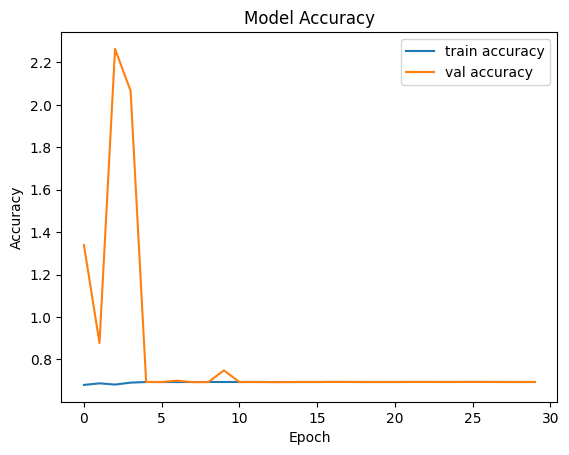

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train accuracy', 'val accuracy'])
plt.show()

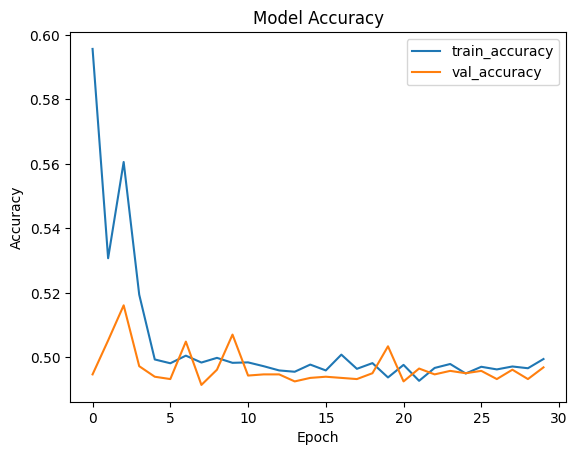

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Confusion matrix

In [40]:
labels = []
inp = []

for x, y in test_dataset.as_numpy_iterator():
  labels.append(y)
  inp.append(x)

In [43]:
inp[0].shape

(1, 224, 224, 3)

In [24]:
# print(np.array(inp.shape()))

In [1]:
labels = np.array([i for i in labels])
labels
# predicted = model.predict([inp[:, 0,...]])
predicted = model.predict(np.array(inp))
# print(predicted[:,0])

NameError: ignored

In [26]:
print(labels.shape)

(2757,)


In [27]:
print(predicted.shape)

(2757, 1)


In [28]:
print(predicted[:,0].shape)
predicted = predicted[:,0]

(2757,)


In [29]:
threshold = 0.4

cm = confusion_matrix(labels, predicted > threshold)
print(cm)

[[   0 1397]
 [   0 1360]]


Text(0.5, 58.7222222222222, 'Predicted')

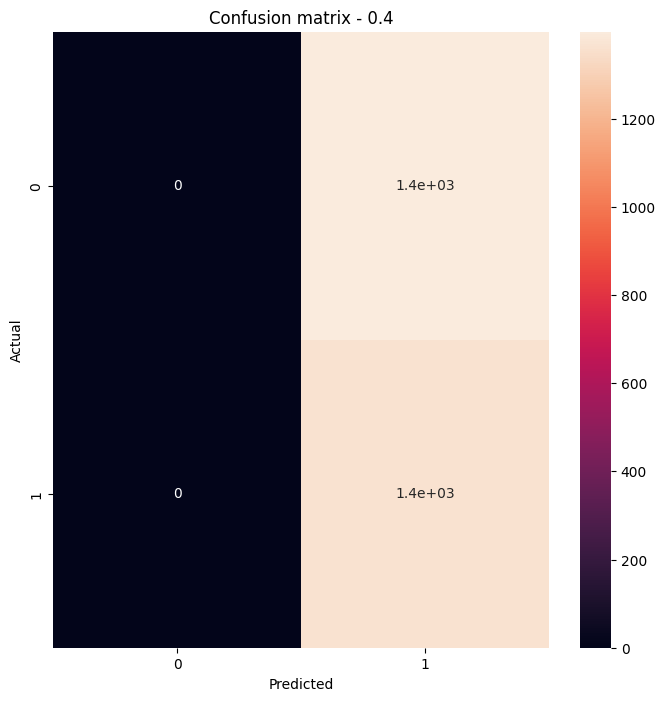

In [30]:
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

# ROC Plots

In [31]:
fp, tp, thresholds = roc_curve(labels, predicted)
print(len(fp), len(tp), len(thresholds))

7 7 7


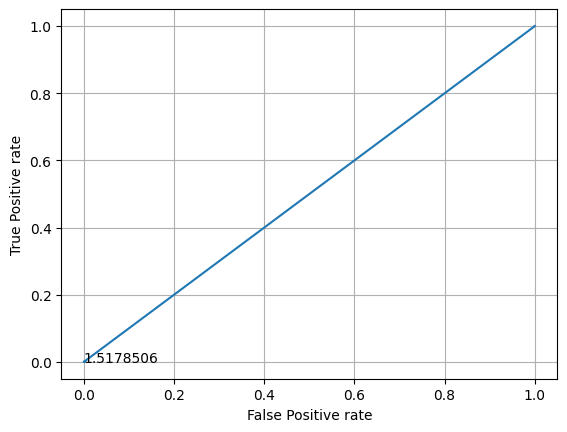

In [32]:
plt.plot(fp, tp)
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.grid()

skip = 20

for i in range(0, len(thresholds), skip):
  plt.text(fp[i], tp[i], thresholds[i])
plt.show()

# Model Evaluation and testing

In [33]:
test_dataset = test_dataset.batch(1)

In [34]:
model.evaluate(test_dataset)

2757/2757 [==============================] - 27s 6ms/step - loss: 0.6935 - tp: 0.0000e+00 - fp: 1.0000 - tn: 1382.0000 - fn: 1374.0000 - accuracy: 0.5013 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4996


[0.6935283541679382,
 0.0,
 1.0,
 1382.0,
 1374.0,
 0.501269519329071,
 0.0,
 0.0,
 0.49963846802711487]

In [35]:
def parasite_or_not(x):
  if (x < 0.5):
    return str('P')
  else:
    return str('U')

In [36]:
parasite_or_not(model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 12s 12s/step


'P'

1/1 [==============================] - 0s 19ms/step


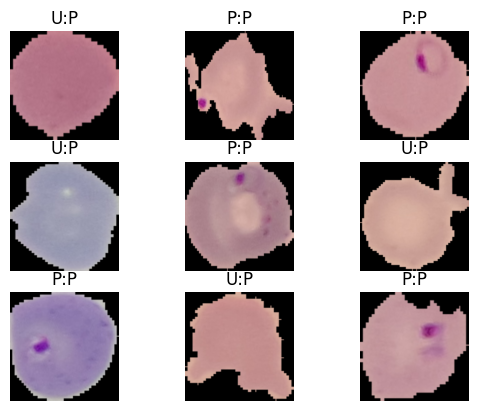

In [37]:
for i, (image, label) in enumerate(test_dataset.take(9)):

  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(model.predict(image)[0][0])))

  plt.axis('off')